In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping


2024-04-27 23:39:22.600179: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-27 23:39:22.934399: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-27 23:39:22.934480: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-27 23:39:22.992355: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-27 23:39:23.113742: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-27 23:39:23.115638: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
# 载入数据
file_path = 'Dataset_new.xlsx'
data = pd.read_excel(file_path)


In [3]:
print(data.columns)

Index(['x1', 'x2', 'x3', 'wavelength', 'spin'], dtype='object')


In [4]:
# 特征和标签
X = data[['x1', 'x2', 'x3']].values
# y_spin = data[['y1', 'y2', 'y3']].values
y_spin = data[['spin']].values
y_wavelength = to_categorical(data['wavelength'].values - 1, num_classes=7)  # 减1是因为to_categorical从0开始索引



In [25]:
# 拆分数据集
X_train, X_test, y_spin_train, y_spin_test, y_wavelength_train, y_wavelength_test = train_test_split(
    X, y_spin, y_wavelength, test_size=0.2, random_state=42)# stratify=y_wavelength.argmax(axis=1)


# nn model
input_layer = Input(shape=(X.shape[1],))
hidden_layer_1 = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(input_layer)
bn1 = BatchNormalization()(hidden_layer_1)
drop_out_1 = Dropout(0.3)(bn1)  # 调整Dropout比率
hidden_layer_2 = Dense(256, activation='relu')(drop_out_1)
bn2 = BatchNormalization()(hidden_layer_2)
drop_out_2 = Dropout(0.3)(bn2)
hidden_layer_3 = Dense(64, activation='relu')(drop_out_2)
bn3 = BatchNormalization()(hidden_layer_3)
drop_out_3 = Dropout(0.3)(bn3)
hidden_layer_final = Dense(128, activation='relu')(drop_out_3)
bn_final = BatchNormalization()(hidden_layer_final)

# 输出层，确保两个输出连接到同一层
spin_output = Dense(1, activation='sigmoid', name='spin_output', kernel_regularizer=l2(0.001))(bn_final)
wavelength_output = Dense(y_wavelength.shape[1], activation='softmax', name='wavelength_output', kernel_regularizer=l2(0.001))(bn_final)


In [27]:
# 创建模型
model = Model(inputs=input_layer, outputs=[spin_output, wavelength_output])

# 损失函数：前三个输出用二元交叉熵，最后一个输出用分类交叉熵
losses = {
    'spin_output': 'binary_crossentropy',
    'wavelength_output': 'categorical_crossentropy'
}

# 编译模型
model.compile(optimizer=Adam(), loss=losses, metrics=['accuracy'])



In [28]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

In [55]:
# 训练模型
model.fit(X_train, [y_spin_train, y_wavelength_train], 
          validation_data=(X_test, [y_spin_test, y_wavelength_test]), 
          epochs=100, 
          batch_size=32)


Epoch 1/100
4/4 [==============================] - 0s 40ms/step - loss: 0.5557 - spin_output_loss: 0.0662 - wavelength_output_loss: 0.4657 - spin_output_accuracy: 0.9732 - wavelength_output_accuracy: 0.8036 - val_loss: 1.1903 - val_spin_output_loss: 0.3486 - val_wavelength_output_loss: 0.8179 - val_spin_output_accuracy: 0.8929 - val_wavelength_output_accuracy: 0.7500
Epoch 2/100
4/4 [==============================] - 0s 43ms/step - loss: 0.5519 - spin_output_loss: 0.1011 - wavelength_output_loss: 0.4271 - spin_output_accuracy: 0.9821 - wavelength_output_accuracy: 0.8304 - val_loss: 1.2024 - val_spin_output_loss: 0.3360 - val_wavelength_output_loss: 0.8426 - val_spin_output_accuracy: 0.9286 - val_wavelength_output_accuracy: 0.7143
Epoch 3/100
4/4 [==============================] - 0s 38ms/step - loss: 0.5472 - spin_output_loss: 0.0956 - wavelength_output_loss: 0.4278 - spin_output_accuracy: 0.9643 - wavelength_output_accuracy: 0.8393 - val_loss: 1.2027 - val_spin_output_loss: 0.3095 - v

In [9]:
# model = load_model('model()_.h5')

In [57]:
# print the training loss and accuracy
training_history = model.history
print('Training Loss:', min(training_history.history['loss']))
# print the minimum training loss
# print('Minimum Training Loss:', min(history.history['loss']))

print('Training Spin Loss:', min(training_history.history['spin_output_loss']))
print('Training Wavelength Loss:', min(training_history.history['wavelength_output_loss']))

print('Training Spin Accuracy:', min(training_history.history['spin_output_accuracy']))
print('Training Wavelength Accuracy:', max(training_history.history['wavelength_output_accuracy']))


#ptint the minimum validation loss
print('Minimum Test Loss:', min(training_history.history['val_loss']))
print('Val Spin Loss:', min(training_history.history['val_spin_output_loss']))
print('Val Wavelength Loss:', min(training_history.history['val_wavelength_output_loss']))



print('Val Spin Accuracy:', min(training_history.history['val_spin_output_accuracy']))
print('Val Wavelength Accuracy:', max(training_history.history['val_wavelength_output_accuracy']))


Training Loss: 0.36308881640434265
Training Spin Loss: 0.04288952797651291
Training Wavelength Loss: 0.2588064968585968
Training Spin Accuracy: 0.9375
Training Wavelength Accuracy: 0.9017857313156128
Minimum Test Loss: 0.8891851305961609
Val Spin Loss: 0.23123988509178162
Val Wavelength Loss: 0.593351423740387
Val Spin Accuracy: 0.8928571343421936
Val Wavelength Accuracy: 0.8571428656578064


In [58]:
# evaluate the model
loss, spin_loss, wavelength_loss, spin_accuracy, wavelength_accuracy = model.evaluate(X_test, [y_spin_test, y_wavelength_test])

print('Spin Loss:', spin_loss)
print('Wavelength Loss:', wavelength_loss)
print('Spin Accuracy:', spin_accuracy)
print('Wavelength Accuracy:', wavelength_accuracy)




1/1 [==============================] - 0s 50ms/step - loss: 1.0792 - spin_output_loss: 0.3577 - wavelength_output_loss: 0.6971 - spin_output_accuracy: 0.9286 - wavelength_output_accuracy: 0.8571
Spin Loss: 0.3577260971069336
Wavelength Loss: 0.6970973014831543
Spin Accuracy: 0.9285714030265808
Wavelength Accuracy: 0.8571428656578064


In [59]:
model.summary()
# draw the model

from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)

# save the model
model.save('model_0427.h5')  


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 3)]                  0         []                            
                                                                                                  
 dense_5 (Dense)             (None, 128)                  512       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_1 (Bat  (None, 128)                  512       ['dense_5[0][0]']             
 chNormalization)                                                                                 
                                                                                                  
 dropout_4 (Dropout)         (None, 128)                  0         ['batch_normalization_1[

/home/guoguo/anaconda3/envs/photocurrent/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


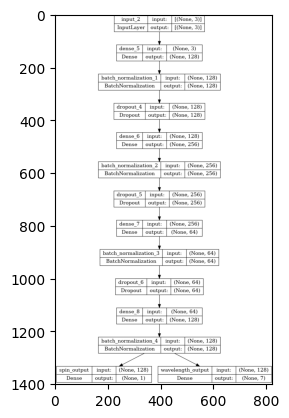

In [60]:
# draw the model structure
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)
img = plt.imread('model.png')
plt.imshow(img)
plt.show()


In [61]:
# draw the accuracy of the model
from sklearn.metrics import accuracy_score

y_pred_w = model.predict(X_test)[1] # 取出Wavelength的预测结果
y_pred_w = np.argmax(y_pred_w, axis=1) + 1  # 取出最大值的索引，加1是因为to_categorical从0开始索引
y_true_w = np.argmax(y_wavelength_test, axis=1) + 1

accuracy = accuracy_score(y_true_w, y_pred_w)
print('Accuracy:', accuracy)




1/1 [==============================] - 0s 178ms/step
Accuracy: 0.8571428571428571


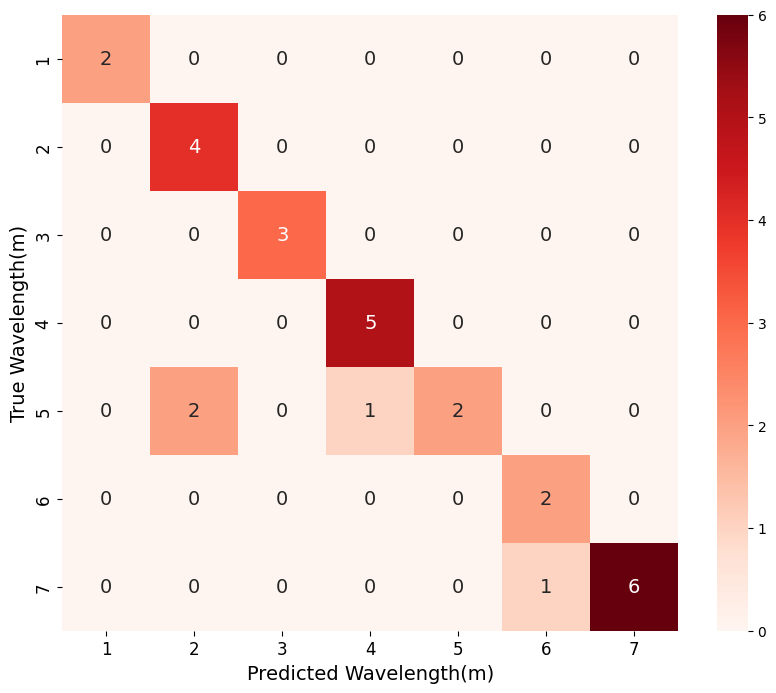

In [62]:
# draw the confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
fig = plt.figure(figsize=(10, 8))
confusion = confusion_matrix(y_true_w, y_pred_w)
sns.heatmap(confusion, annot=True, fmt='d', cmap='Reds', square=True, annot_kws={"size": 14})
# chaneg the x,y from 1-7
plt.xticks(np.arange(7) + 0.5, range(1, 8), fontsize=12)
plt.yticks(np.arange(7) + 0.5, range(1, 8), fontsize=12)
# add the unit（um） of x,y axis

plt.xlabel('Predicted Wavelength(m)', fontsize=14)
plt.ylabel('True Wavelength(m)', fontsize=14)
# plt.gca().invert_yaxis()
plt.show()





1/1 [==============================] - 0s 27ms/step


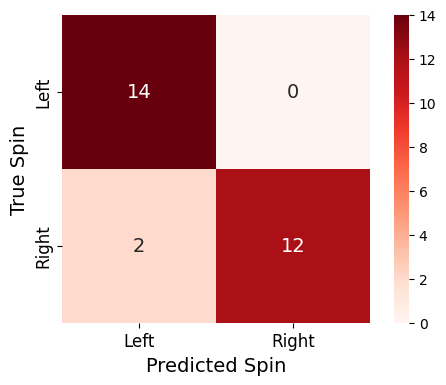

In [63]:
# draw the confusion matrix of spin

y_pred_s = model.predict(X_test)[0]  # 取出Spin的预测结果
y_pred_s = np.round(y_pred_s).flatten()  # 四舍五入
y_true_s = y_spin_test.flatten()

confusion = confusion_matrix(y_true_s, y_pred_s)
fig = plt.figure(figsize=(6, 4))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Reds', square=True, annot_kws={"size": 14})
plt.xlabel('Predicted Spin', fontsize=14)
plt.ylabel('True Spin', fontsize=14)
plt.xticks([0.5, 1.5], ['Left', 'Right'], fontsize=12)
plt.yticks([0.5, 1.5], ['Left', 'Right'], fontsize=12)
plt.show()




1/1 [==============================] - 0s 24ms/step


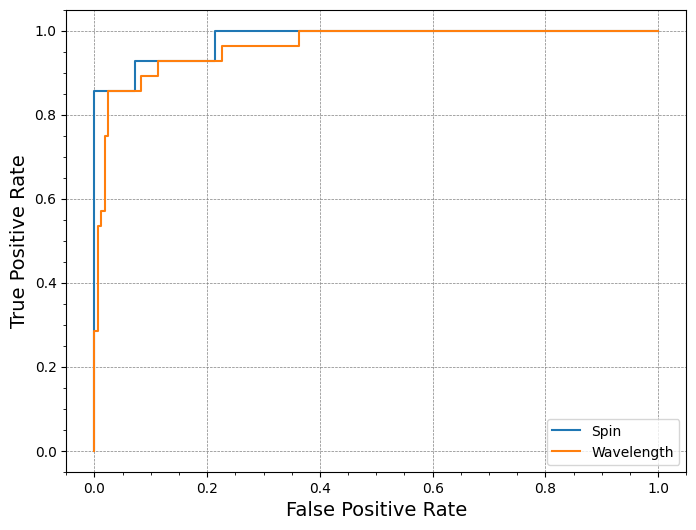

In [64]:
# draw the ROC curve of the model for spin and wavelength prediction
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

y_pred_s = model.predict(X_test)[0]  # 取出Spin的预测结果
y_pred_s = y_pred_s.flatten()
y_true_s = y_spin_test

y_pred_w = model.predict(X_test)[1]  # 取出Wavelength的预测结果
y_pred_w = y_pred_w.flatten()
y_true_w = np.argmax(y_wavelength_test, axis=1)


# draw the ROC curve of spin and wavelength in the same figure
fig = plt.figure(figsize=(8, 6))
fpr, tpr, thresholds = roc_curve(y_true_s, y_pred_s)
plt.plot(fpr, tpr, label='Spin')
fpr, tpr, thresholds = roc_curve(y_wavelength_test.ravel(), y_pred_w.ravel())
plt.plot(fpr, tpr, label='Wavelength')
# plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.grid( linestyle='--', color='gray', linewidth=0.5)
plt.minorticks_on()
plt.legend()
plt.show()











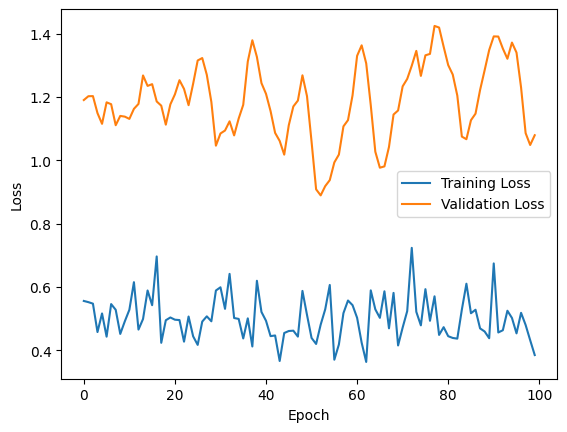

In [65]:
# plot the training loss of the model
import matplotlib.pyplot as plt
plt.plot(training_history.history['loss'], label='Training Loss')
plt.plot(training_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

 


In [69]:
# test the model use a new data
X_new = np.array([[0.53, -0.16, 1]])
y_pred = model.predict(X_new)
if y_pred[0] < 0.5:
    y_pred[0] = 0
else:
    y_pred[0] = 1

y_pred[1] = np.argmax(y_pred[1]) + 1
print('Spin:', y_pred[0])
print('Wavelength range:', y_pred[1])
# print('true_w',y_wavelength_test)

1/1 [==============================] - 0s 39ms/step
Spin: 0
Wavelength range: 1


In [70]:
# test the model use a new data
X_new = np.array([[0.01, -1, -0.54]])
y_pred = model.predict(X_new)
if y_pred[0] < 0.5:
    y_pred[0] = 0
else:
    y_pred[0] = 1

y_pred[1] = np.argmax(y_pred[1]) + 1
print('Spin:', y_pred[0])
print('Wavelength range:', y_pred[1])

1/1 [==============================] - 0s 51ms/step
Spin: 0
Wavelength range: 7


In [76]:
y_pred = model.predict(X_new)
print(y_pred)

1/1 [==============================] - 0s 65ms/step
[array([[0.00085186]], dtype=float32), array([[1.3449675e-04, 1.1146749e-04, 1.0514270e-04, 2.8234077e-05,
        3.3917233e-05, 7.1379788e-02, 9.2820692e-01]], dtype=float32)]


In [71]:
# lode a new data from excel
file_path = 'Dataset_MLtest.xlsx'
data = pd.read_excel(file_path)
X = data[['x1', 'x2', 'x3']].values
y_spin = data[['spin']].values
y_wavelength = to_categorical(data['wavelength'].values - 1, num_classes=7)  # 减1是因为to_categorical从0开始索引

In [77]:
y_pred = model.predict(X)
y_pred_s = y_pred[0].flatten()
y_pred_s = np.round(y_pred_s)
y_true_s = y_spin.flatten()
spin_acc = accuracy_score(y_true_s, y_pred_s)
print('Spin Accuracy:', spin_acc)
y_pred_w = y_pred[1]
# save the y_pred_w, y_true_w to a excel file

df = pd.DataFrame({'y_pred_w': y_pred_w.flatten()})
df.to_excel('wavelength_prediction.xlsx', index=False)
df = pd.DataFrame({'y_true_w': y_true_w})
df.to_excel('wavelength_true.xlsx', index=False)


y_pred_w = np.argmax(y_pred_w, axis=1) + 1
y_true_w = np.argmax(y_wavelength, axis=1) + 1
wavelength_acc = accuracy_score(y_true_w, y_pred_w)
print('Wavelength Accuracy:', wavelength_acc)



1/1 [==============================] - 0s 62ms/step
Spin Accuracy: 1.0


ValueError: All arrays must be of the same length

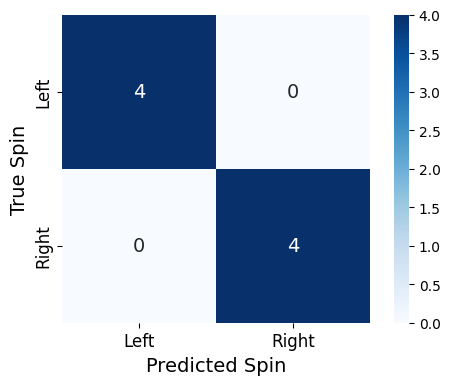

In [73]:
# draw the confusion matrix of spin and wavelength



fig = plt.figure(figsize=(6, 4))
confusion = confusion_matrix(y_true_s, y_pred_s)
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', square=True, annot_kws={"size": 14})
plt.xlabel('Predicted Spin', fontsize=14)
plt.ylabel('True Spin', fontsize=14)
plt.xticks([0.5, 1.5], ['Left', 'Right'], fontsize=12)
plt.yticks([0.5, 1.5], ['Left', 'Right'], fontsize=12)
plt.show()

[1 1 2 2 4 4 7 7]
[1 1 2 2 4 4 7 7]


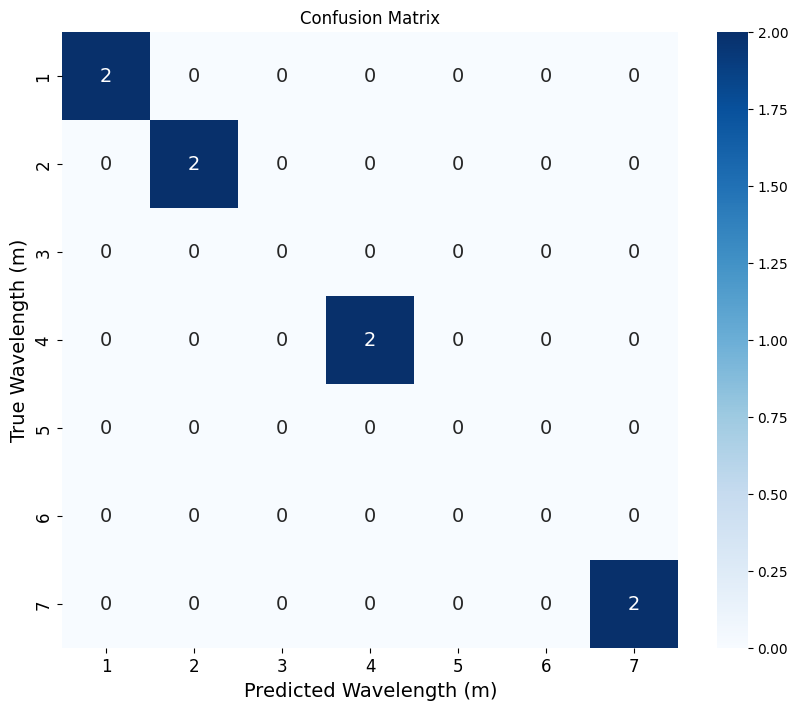

In [74]:
# all_calss = np.arange(1, 8)
print(y_true_w)
print(y_pred_w)

all_classes = np.arange(1, 8)  # 从1到7的类别

# 生成混淆矩阵，明确指定类别标签
confusion = confusion_matrix(y_true_w, y_pred_w, labels=all_classes)

# 绘制热图
fig = plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', square=True, annot_kws={"size": 14})
plt.xlabel('Predicted Wavelength (m)', fontsize=14)
plt.ylabel('True Wavelength (m)', fontsize=14)
plt.xticks(np.arange(len(all_classes)) + 0.5, all_classes, fontsize=12)  # 设置x轴标签
plt.yticks(np.arange(len(all_classes)) + 0.5, all_classes, fontsize=12)  # 设置y轴标签
plt.title('Confusion Matrix')
plt.show()